<a href="https://colab.research.google.com/github/Aratrika-cs/AML/blob/main/AML_Final_Project_Aratrika_Mustafi_GAN_to_WGAN_SVHN_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import tensorflow as tf
import torchvision
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import argparse
import subprocess
import json

from tensorflow.keras import layers
from pathlib import Path
from tensorflow.keras.utils import plot_model
from IPython import display

# Helper functions 

def _get_params_dir():
  """Function to obtain the directory path for all stored output (On Google Drive)
  """
  return os.path.join(Path.home(), 'AML_Final_Project')

def make_dir_if_not_exists(save_file):
  """Utility function for creating necessary directories for a specified filename.
  Parameters
  ----------
  save_file : :obj:`str`
      absolute path of save file
  """
  save_dir = os.path.dirname(save_file)
  if not os.path.exists(save_dir):
      os.makedirs(save_dir)

def take_input():
  """Set up information about the model"""

  model_param = {
      'model': ['Model to fit GAN/WGANLP: ', str],
      'dataset': ['Dataset to use MNIST/SVHN: ', str],
      'output': ['Directory to save the output: ', str],
      'batch_size': ['Size of the batch used in training: ', int],
      'noise_dim': ['Dimension of the latent noise: ', int],
      'total_epoch': ['Number of training epochs: ', int],
      'critic_step': ['The number of steps to apply to the discriminator: ', int],
      'visualize': ['Do you want to visualize the training process and the resulting models? (True/False): ', bool],
      'gif': ['Do you want to make a gif of the images generated at each epoch? (True/False): ', bool],
      'save_model_freq': ['How freuently do you want the model to be saved? : ', int],

      # setup the discriminator optimizer
      'learning_rate_d': ['The learning rates of ADAM (discriminator):', float],
      'beta_1_d': ['The exponential decay rates for the 1st moment estimates in ADAM (discriminator): ', float],
      'beta_2_d': ['The exponential decay rates for the 2nd moment estimates in ADAM (discriminator): ', float],
      'epsilon_d': ['Small constants for numerical stability of ADAM (discriminator): ', float],
      'amsgrad_d': ['Logical indicating whether to use the AMSGrad variant of ADAM (discriminator): ', bool],

      # setup the generator optimizer
      'learning_rate_g': ['The learning rates of ADAM (discriminator):', float],
      'beta_1_g': ['The exponential decay rates for the 1st moment estimates in ADAM (discriminator): ', float],
      'beta_2_g': ['The exponential decay rates for the 2nd moment estimates in ADAM (discriminator): ', float],
      'epsilon_g': ['Small constants for numerical stability of ADAM (discriminator): ', float],
      'amsgrad_g': ['Logical indicating whether to use the AMSGrad variant of ADAM (discriminator): ', bool]
  }

  print('Please enter the following information:')
  for key, val in model_param.items():
      if val[1] == bool:
          model_param[key] = True if input(val[0]).lower() == 'true' else False
      else:
          model_param[key] = val[1](input(val[0]))

  if model_param.get("model") == "WGANLP":
      params_WGANLP = {
          'grad_penalty': ['Penalty controlling the strength of the gradient regularization in WGAN-LP:' , float],
          'perturb_factor': ['Factor controlling the standard deviation of perturbation for generating samples to compute the gradient penalty in WGAN-LP:', float],
      }
      print('Please enter the following information for WGAN-LP:')
      for key, val in params_WGANLP.items():
          if val[1] == bool:
              params_WGANLP[key] = True if input(val[0]).lower() == 'true' else False
          else:
              params_WGANLP[key] = val[1](input(val[0]))

  params_dir = _get_params_dir()
  if not os.path.exists(params_dir):
      os.makedirs(params_dir)
  params_file = os.path.join(
      params_dir, str('%s_%s_params.json' % (model_param['dataset'], model_param['model'])))
  with open(params_file, 'w') as f:
      json.dump(model_param, f, sort_keys=False, indent=4)

  # print('Dataset params are now stored in %s' % params_file)

  return model_param

#################### Main functions #####################

def fit_model(input,model_parameters):
  """Function to implement a GAN or WGAN on MNIST or SVHN Datasets
     based on parameters passed in as either direct user input or
     as a dictionary
  Parameters
  ----------
  input : :obj: bool
      flag, if TRUE takes user input directly, otherise
      accepts a dictionary of model hyperparameters
  model_parameters : :obj: Dictionary
      Dictionary of model hyperparameters
  """
  # Setup the model hyperparameters
  if input:
    model_param = take_input()
  else:
    model_param = model_parameters
  
  make_dir_if_not_exists(model_param.get("output"))
  #if not os.path.exists(model_param.get("output")) or not os.path.isdir(model_param.get("output")):
        #raise OSError("Output path does not exist or is not a directory.")
  
  model_param['output'] = os.path.normpath(model_param.get("output"))
  
  if model_param.get("model") == "GAN":
    model = GAN(model_param)
  else:
    model = WGAN_LP(model_param)

  # Train the model
  model.train()

  # Upon user demand, randomly generate 100 image samples and plot the evolution of the discriminator and genertaor losses
  if model_param.get("visualize"):
      vis_seed = tf.random.uniform([100, model.noise_dim])
      vis_gen = model.G(vis_seed, training=False)
      if model_param.get("dataset") == "MNIST":
          plt.figure(figsize=(4.8, 4.8))
      else:
          plt.figure(figsize=(5.4, 5.4))
      for i in range(vis_gen.shape[0]):
          x_pos = i % 10
          y_pos = int(i / 10)
          if model_param.get("dataset") == "MNIST":
              plt.figimage(vis_gen[i, :, :, 0] * 127.5 + 127.5,
                            10 + x_pos * (28 + 5), 10 + y_pos * (28 + 5), cmap='gray')
          else:
              plt.figimage((vis_gen[i, :, :] + 1) / 2,
                            10 + x_pos * (32 + 5), 10 + y_pos * (32 + 5))
          plt.axis('off')
      make_dir_if_not_exists(os.path.join(model_param.get("output"),
                                "{}_{}_Example.png".format(model_param.get("model"), model_param.get("dataset"))))    
      plt.savefig(os.path.join(model_param.get("output"),
                                "{}_{}_Example.png".format(model_param.get("model"), model_param.get("dataset"))))

      # plot median value of the objective functions
      plt.figure()
      plt.title("Objective Functions of {} (Dataset: {})".format(model_param.get("model"), model_param.get("dataset")))
      plt.xlabel("Epoch")
      plt.ylabel("Median Value")
      plt.plot(range(1, 1 + model_param.get("total_epoch")), np.median(model.d_obj, axis=[-0, -1]))
      plt.plot(range(1, 1 + model_param.get("total_epoch")), np.median(model.g_obj, axis=[-0]))
      plt.legend(['Discriminator', 'Generator'])
      plt.savefig(os.path.join(model_param.get("output"),
                                "{}_{}_Objective.png".format(model_param.get("model"), model_param.get("dataset"))))
  if model_param.get("gif"):
      model.make_gif(model_param)

  return model, model.d_obj, model.g_obj

# Function to generate images
def model_generate(model,visualize=True,n=100,save_file_path="Generated images.png",plot_title="Generated images"):
  generated_images = model.generate(n)
  gen_images = generated_images[:100]
  fig = plt.figure(figsize=(10, 10))
  plt.suptitle(plot_title)
  for i in range(gen_images.shape[0]):
    plt.subplot(10, 10, i + 1)
    if model.data_shape[3] == 1:
        plt.imshow(gen_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    else:
        plt.imshow((gen_images[i, :, :] + 1) / 2)
    plt.axis('off')
  make_dir_if_not_exists(os.path.join(model.out_path, save_file_path.format(model.dataset)))
  plt.savefig(os.path.join(model.out_path, save_file_path.format(model.dataset)))
  plt.clf()
  plt.close(fig)
  np.save(model.out_path+"Gen_images_array.npy",generated_images)
  return generated_images

class GAN:
  def __init__(self, param):
    # load data
      self.dataset = param.get("dataset", -1)

      # choose CNN setup for the dataset
      if self.dataset == "MNIST":
        (self.x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
        self.init_dim = 7
        self.strides = (1, 2, 2)
        self.data_shape = self.x_train.shape + (1,)
      elif self.dataset == "SVHN":
        self.x_train = torchvision.datasets.SVHN(root='./AML_Final_Project/data/SVHN/',split="train",download=True).data[:30000]
        # shape = self.x_train.shape
        # self.x_train = self.x_train.reshape(shape[0],shape[3],shape[2],shape[1])
        self.x_train = self.x_train.mean(1)
        # self.init_dim = 4
        # self.strides = (2, 2, 2)
        # self.data_shape = self.x_train.shape
        self.init_dim = 7
        self.strides = (1, 2, 2)
        self.data_shape = self.x_train.shape + (1,)
      else:
        raise ValueError('Dataset not supported.')

      # get basic inputs
      self.batch_size = param.get("batch_size", 128)
      self.noise_dim = param.get("noise_dim", 128)
      self.total_epoch = param.get("total_epoch", 100)
      self.critic_step = param.get("critic_step", 1)
      self.visualize = param.get("visualize", True)
      self.out_path = param.get("output", "/content/gdrive/My Drive/AML_Final_Project/fileoutputs")
      self.save_model_freq = param.get("save_model_freq", 1)
      # storage for the objectives
      self.batch_num = int(self.data_shape[0] / self.batch_size) + (self.data_shape[0] % self.batch_size != 0)
      self.d_obj = np.zeros([self.batch_num, self.total_epoch, self.critic_step])
      self.g_obj = np.zeros([self.batch_num, self.total_epoch])

      # normalize dataset
      self.x_train = self.x_train.reshape(self.data_shape).astype('float32')
      self.x_train = (self.x_train - 127.5) / 127.5  # Normalize RGB to [-1, 1]
      self.x_train = tf.data.Dataset.from_tensor_slices(self.x_train).shuffle(self.data_shape[0]).batch(self.batch_size)

      # setup optimizers
      self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=param.get("learning_rate_g", 5e-5),
                                                  beta_1=param.get("beta_1_g", 0.5),
                                                  beta_2=param.get("beta_2_g", 0.999),
                                                  epsilon=param.get("epsilon_g", 1e-7),
                                                  amsgrad=param.get("amsgrad_g", False))
      self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=param.get("learning_rate_d", 1e-4),
                                                  beta_1=param.get("beta_1_d", 0.5),
                                                  beta_2=param.get("beta_2_d", 0.999),
                                                  epsilon=param.get("epsilon_d", 1e-7),
                                                  amsgrad=param.get("amsgrad_d", False))
      # setup models
      self.G = self.set_generator()
      self.D = self.set_discriminator()

  def set_generator(self):
    g = tf.keras.Sequential()
    g.add(layers.Dense(self.init_dim * self.init_dim * 256, use_bias=False, input_shape=(self.noise_dim,)))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())
    g.add(layers.Reshape((self.init_dim, self.init_dim, 256)))

    g.add(layers.Conv2DTranspose(128, 5, strides=self.strides[0], padding='same', use_bias=False))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())

    g.add(layers.Conv2DTranspose(64, 5, strides=self.strides[1], padding='same', use_bias=False))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())

    g.add(layers.Conv2DTranspose(32, 5, strides=self.strides[2], padding='same', use_bias=False))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())

    g.add(layers.Conv2DTranspose(self.data_shape[3], 5, padding='same', use_bias=False, activation='tanh'))

    return g

  def set_discriminator(self):
    d = tf.keras.Sequential()
    d.add(layers.Conv2D(32, kernel_size=5, strides=2, padding='same',
                        input_shape=self.data_shape[1:],
                        kernel_initializer="glorot_uniform"))
    d.add(layers.LeakyReLU())
    d.add(layers.Dropout(0.2))

    d.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same'))
    d.add(layers.BatchNormalization())
    d.add(layers.LeakyReLU())
    d.add(layers.Dropout(0.2))

    d.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    d.add(layers.BatchNormalization())
    d.add(layers.LeakyReLU())
    d.add(layers.Dropout(0.5))

    d.add(layers.Conv2D(256, kernel_size=5, strides=2, padding='same'))
    d.add(layers.BatchNormalization())
    d.add(layers.LeakyReLU())

    d.add(layers.Flatten())
    d.add(layers.Dense(2, activation='softmax'))
    d.add(layers.Lambda(lambda x: x[:, 0]))

    return d

  @tf.function
  def train_discriminator(self, x_batch):
    with tf.GradientTape() as D_tape:
      x_gen = self.G(tf.random.uniform([x_batch.shape[0], self.noise_dim]), training=True)
      y_real = self.D(x_batch, training=True)
      y_gen = self.D(x_gen, training=True)

      # compute the objective
      # loss_real = tf.math.log(tf.clip_by_value(y_real, 1e-10, 1.0))
      # loss_gen = tf.math.log(tf.clip_by_value(tf.math.add(1.0, tf.math.negative(y_gen)), 1e-10, 1.0))
      loss_real = tf.math.log(y_real)
      loss_gen = tf.math.log(tf.math.add(1.0, tf.math.negative(y_gen)))
      d_obj = -tf.math.reduce_mean(loss_real) - tf.math.reduce_mean(loss_gen)
      # update the discriminator
      d_grad = D_tape.gradient(d_obj, self.D.trainable_variables)
      self.D_optimizer.apply_gradients(zip(d_grad, self.D.trainable_variables))
          
    return d_obj

  @tf.function
  def train_generator(self, x_batch_size):
    with tf.GradientTape() as G_tape:
      x_gen = self.G(tf.random.uniform([x_batch_size, self.noise_dim]), training=True)
      y_gen = self.D(x_gen, training=True)

      # compute the objective
      #g_obj = -tf.math.reduce_mean(tf.math.log(tf.clip_by_value(y_gen, 1e-10, 1.0)))
      g_obj = tf.math.reduce_mean(tf.math.log(tf.clip_by_value(tf.math.add(1.0, tf.math.negative(y_gen)), 1e-10, 1.0)))
      # update the generator
      g_grad = G_tape.gradient(g_obj, self.G.trainable_variables)
      self.G_optimizer.apply_gradients(zip(g_grad, self.G.trainable_variables))

    return g_obj

  def train(self):
    vis_seed = None
    if self.visualize:
      # Seed for checking training progress
      vis_seed = tf.random.uniform([16, self.noise_dim])

      # Record current time and start training
      print("Training...")
      ts_start = tf.timestamp()
      for t in range(self.total_epoch):
        batch_id = 0
        for b in self.x_train:
          for k in range(self.critic_step):
            self.d_obj[batch_id, t, k] = self.train_discriminator(b)
            #print(self.train_generator(self.batch_size))    
            self.g_obj[batch_id, t] = self.train_generator(b.shape[0])
            batch_id += 1
          
        checkpoint_dir = './training_checkpoints/'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.G_optimizer,
                                        discriminator_optimizer=self.D_optimizer,
                                        generator=self.G,
                                        discriminator=self.D)

        # Save the model every epoch
        if (t + 1) % self.save_model_freq == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

        # Print time
        print("Time used for epoch {} are {:0.2f} seconds.".format(t + 1, tf.timestamp() - ts_start))

        # Check current generator
        if self.visualize:
          vis_gen = self.G(vis_seed, training=False)
          fig = plt.figure(figsize=(4, 4))
          plt.suptitle('Epoch: {:03d}'.format(t + 1))
          for i in range(vis_gen.shape[0]):
            plt.subplot(4, 4, i + 1)
            if self.data_shape[3] == 1:
              plt.imshow(vis_gen[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            else:
              plt.imshow((vis_gen[i, :, :] + 1) / 2)
            plt.axis('off')
          make_dir_if_not_exists(os.path.join(self.out_path, "GAN_{}_Epoch_{:03d}.png".format(self.dataset, t + 1)))
          plt.savefig(os.path.join(self.out_path, "GAN_{}_Epoch_{:03d}.png".format(self.dataset, t + 1)))
          plt.clf()
          plt.close(fig)
      print("Done! {:0.2f} seconds have passed.".format(tf.timestamp() - ts_start))

  def generate(self, n_samples):
    x_gen = self.G(tf.random.uniform([n_samples, self.noise_dim]), training=False)
    return x_gen

  def restore_ckpt(self):
    checkpoint_dir = checkpoint_dir = self.out_path + '/training_checkpoints/'
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def display_image(self,epoch_no,example=False):
    if example:
      return PIL.Image.open(os.path.join(self.out_path,"GAN_{}_Example.png".format(self.dataset)))
    else:
      return PIL.Image.open(os.path.join(self.out_path, "GAN_{}_Epoch_{:03d}.png".format(self.dataset,epoch_no)))
  
  def make_gif(self,param):
    anim_file = "{}_{}_totalepoch{}.gif".format(param.get("dataset"),param.get("model"),param.get("total_epoch"))

    os.chdir(param.get("output"))
    filenames = glob.glob('GAN_{}_Epoch_*.png'.format(param.get("dataset")))
    filenames = sorted(filenames)
    image=[]
    for i,filename in enumerate(filenames):
      image.append(imageio.imread(filename))
      imageio.mimsave("./"+anim_file,iter(image))
        
    import IPython
    if IPython.version_info > (6,2,0,''):
      display.Image(filename=anim_file)

class WGAN_LP:
  def __init__(self, param):
    # load data
    self.dataset = param.get("dataset", -1)

    # choose CNN setup for each dataset
    if self.dataset == "MNIST":
      (self.x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
      self.init_dim = 7
      self.strides = (2, 2, 1)
      self.data_shape = self.x_train.shape + (1,)
    elif self.dataset == "SVHN":
        self.x_train = torchvision.datasets.SVHN(root='./AML_Final_Project/data/SVHN/',split="train",download=True).data[:30000]
        # shape = self.x_train.shape
        # self.x_train = self.x_train.reshape(shape[0],shape[3],shape[2],shape[1])
        self.x_train = self.x_train.mean(1)
        self.init_dim = 4
        self.strides = (2, 2, 2)
        self.data_shape = self.x_train.shape
        # self.init_dim = 7
        # self.strides = (1, 2, 2)
        # self.data_shape = self.x_train.shape + (1,)
    else:
        raise ValueError('Dataset not supported.')

    # get basic inputs
    self.batch_size = param.get("batch_size", 128)
    self.noise_dim = param.get("noise_dim", 128)
    self.total_epoch = param.get("total_epoch", 100)
    self.critic_step = param.get("critic_step", 1)
    self.visualize = param.get("visualize", True)
    self.out_path = param.get("output", "/content/gdrive/My Drive/GANvWGAN/fileoutputs")
    self.save_model_freq = param.get("save_model_freq", 1)

    # storage for the objectives
    self.batch_num = int(self.data_shape[0] / self.batch_size) + (self.data_shape[0] % self.batch_size != 0)
    self.d_obj = np.zeros([self.batch_num, self.total_epoch, self.critic_step])
    self.g_obj = np.zeros([self.batch_num, self.total_epoch])

    # set regularization parameters
    self.grad_penalty = param.get("grad_penalty", 10.0)
    self.perturb_factor = param.get("perturb_factor", 1.0)

    # normalize dataset
    self.x_train = self.x_train.reshape(self.data_shape).astype('float32')
    self.x_train = (self.x_train - 127.5) / 127.5  # Normalize RGB to [-1, 1]
    self.x_train = tf.data.Dataset.from_tensor_slices(self.x_train).shuffle(self.data_shape[0]).batch(self.batch_size)

    # setup optimizers
    self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=param.get("learning_rate_d", 1e-4),
                                                beta_1=param.get("beta_1_d", 0.5),
                                                beta_2=param.get("beta_2_d", 0.999),
                                                epsilon=param.get("epsilon_d", 1e-7),
                                                amsgrad=param.get("amsgrad_d", False))
    self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=param.get("learning_rate_g", 5e-5),
                                                beta_1=param.get("beta_1_g", 0.2),
                                                beta_2=param.get("beta_2_g", 0.999),
                                                epsilon=param.get("epsilon_g", 1e-7),
                                                amsgrad=param.get("amsgrad_g", False))

    # setup models
    self.G = self.set_generator()
    self.D = self.set_discriminator()

  def set_generator(self):
    g = tf.keras.Sequential()
    g.add(layers.Dense(self.init_dim * self.init_dim * 256, use_bias=False, input_shape=(self.noise_dim,)))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())
    g.add(layers.Reshape((self.init_dim, self.init_dim, 256)))

    g.add(layers.Conv2DTranspose(128, 5, strides=self.strides[0], padding='same', use_bias=False))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())

    g.add(layers.Conv2DTranspose(64, 5, strides=self.strides[1], padding='same', use_bias=False))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())

    g.add(layers.Conv2DTranspose(32, 5, strides=self.strides[2], padding='same', use_bias=False))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())

    g.add(layers.Conv2DTranspose(self.data_shape[3], 5, strides=self.strides[2],
                                  padding='same', use_bias=False, activation='tanh'))

    return g

  def set_discriminator(self):
    d = tf.keras.Sequential()
    d.add(layers.Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=self.data_shape[1:]))
    d.add(layers.LeakyReLU())
    d.add(layers.Dropout(0.2))

    d.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same'))
    d.add(layers.LayerNormalization())
    d.add(layers.LeakyReLU())
    d.add(layers.Dropout(0.2))

    d.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    d.add(layers.LayerNormalization())
    d.add(layers.LeakyReLU())

    d.add(layers.Flatten())
    d.add(layers.Dense(1))

    return d

  @tf.function
  def lipschitz_penalty(self, x, x_hat):
    # DRAGAN-like sampling scheme
    x_join = tf.concat([x, x_hat], axis=0)
    _, batch_var = tf.nn.moments(x_join, axes=[0, 1, 2, 3])
    delta = tf.random.normal(x_join.shape, stddev=self.perturb_factor * tf.sqrt(batch_var))
    x_tilde = x_join + delta

    # compute gradient penalty
    with tf.GradientTape() as D_tape:
      D_tape.watch(x_tilde)
      y_tilde = self.D(x_tilde)
    d_grad = D_tape.gradient(y_tilde, x_tilde)
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(d_grad), axis=[1, 2, 3]))

    return tf.reduce_mean(tf.square(tf.maximum(0.0, grad_norm - 1.0)))

  @tf.function
  def train_discriminator(self, x_batch):
    with tf.GradientTape() as D_tape:
      # sample data
      x_gen = self.G(tf.random.uniform([x_batch.shape[0], self.noise_dim]), training=True)

      # scoring with the discriminator
      y_real = self.D(x_batch, training=True)
      y_gen = self.D(x_gen, training=True)

      # compute the objective
      d_obj = tf.math.reduce_mean(y_gen) - tf.math.reduce_mean(y_real)
      d_obj_pen = d_obj + self.grad_penalty * self.lipschitz_penalty(x_batch, x_gen)
      # update the discriminator
      d_grad = D_tape.gradient(d_obj_pen, self.D.trainable_variables)
      self.D_optimizer.apply_gradients(zip(d_grad, self.D.trainable_variables))

    return d_obj

  @tf.function
  def train_generator(self, x_batch_size):
    with tf.GradientTape() as G_tape:
      x_gen = self.G(tf.random.uniform([x_batch_size, self.noise_dim]), training=True)
      y_gen = self.D(x_gen, training=True)

      # compute the objective
      g_obj = -tf.math.reduce_mean(y_gen)
      # update the generator
      g_grad = G_tape.gradient(g_obj, self.G.trainable_variables)
      self.G_optimizer.apply_gradients(zip(g_grad, self.G.trainable_variables))

    return g_obj

  def train(self):
    vis_seed = None
    if self.visualize:
      # Seed for checking training progress
      vis_seed = tf.random.uniform([16, self.noise_dim])

      # Record current time and start training
      print("Training...")
      ts_start = tf.timestamp()
      for t in range(self.total_epoch):
        batch_id = 0
        for b in self.x_train:
          for k in range(self.critic_step):
            self.d_obj[batch_id, t, k] = self.train_discriminator(b)
          self.g_obj[batch_id, t] = self.train_generator(b.shape[0])
          batch_id += 1
        
        checkpoint_dir = self.out_path + '/training_checkpoints/'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.G_optimizer,
                                        discriminator_optimizer=self.D_optimizer,
                                        generator=self.G,
                                        discriminator=self.D)

        # Save the model every epoch
        if (t + 1) % self.save_model_freq == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

        # Print time
        print("Time used for epoch {} are {:0.2f} seconds.".format(t + 1, tf.timestamp() - ts_start))

        # Check current generator
        if self.visualize:
          vis_gen = self.G(vis_seed, training=False)
          fig = plt.figure(figsize=(4, 4))
          plt.suptitle('Epoch: {:03d}'.format(t + 1))
          for i in range(vis_gen.shape[0]):
            plt.subplot(4, 4, i + 1)
            if self.data_shape[3] == 1:
                plt.imshow(vis_gen[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            else:
                plt.imshow((vis_gen[i, :, :] + 1) / 2)
            plt.axis('off')
          make_dir_if_not_exists(os.path.join(self.out_path, "WGAN_LP_{}_Epoch_{:03d}.png".format(self.dataset, t + 1)))
          plt.savefig(os.path.join(self.out_path, "WGAN_LP_{}_Epoch_{:03d}.png".format(self.dataset, t + 1)))
          
          plt.clf()
          plt.close(fig)
      print("Done! {:0.2f} seconds have passed.".format(tf.timestamp() - ts_start))

  def generate(self, n_samples):
    x_gen = self.G(tf.random.uniform([n_samples, self.noise_dim]), training=False)
    return x_gen
  
  def restore_ckpt(self):
    checkpoint_dir = checkpoint_dir = self.out_path + '/training_checkpoints/'
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def display_image(self,epoch_no):
    return PIL.Image.open(os.path.join(self.out_path, "WGAN_LP_{}_Epoch_{:03d}.png".format(self.dataset,epoch_no)))
  
  def display_image(self,epoch_no,example=False):
    if example:
      return PIL.Image.open(os.path.join(self.out_path,"WGANLP_{}_Example.png".format(self.dataset)))
    else:
      return PIL.Image.open(os.path.join(self.out_path, "WGAN_LP_{}_Epoch_{:03d}.png".format(self.dataset,epoch_no)))

  def make_gif(self,param):
    anim_file = "{}_{}_totalepoch{}.gif".format(param.get("dataset"),param.get("model"),param.get("total_epoch"))

    os.chdir(param.get("output"))
    filenames = glob.glob('WGAN_LP_{}_Epoch_*.png'.format(param.get("dataset")))
    filenames = sorted(filenames)
    image=[]
    for i,filename in enumerate(filenames):
      image.append(imageio.imread(filename))
      imageio.mimsave("./"+anim_file,iter(image))
        
    import IPython
    if IPython.version_info > (6,2,0,''):
      display.Image(filename=anim_file)

In [21]:
import os
os.chdir('/content/drive/My Drive')

In [22]:
%pwd

'/content/drive/My Drive'

Using downloaded and verified file: ./AML_Final_Project/data/SVHN/train_32x32.mat
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12544)             1605632   
_________________________________________________________________
batch_normalization_28 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_29 (Batc (None, 7, 7, 128)         512       
______________________________________

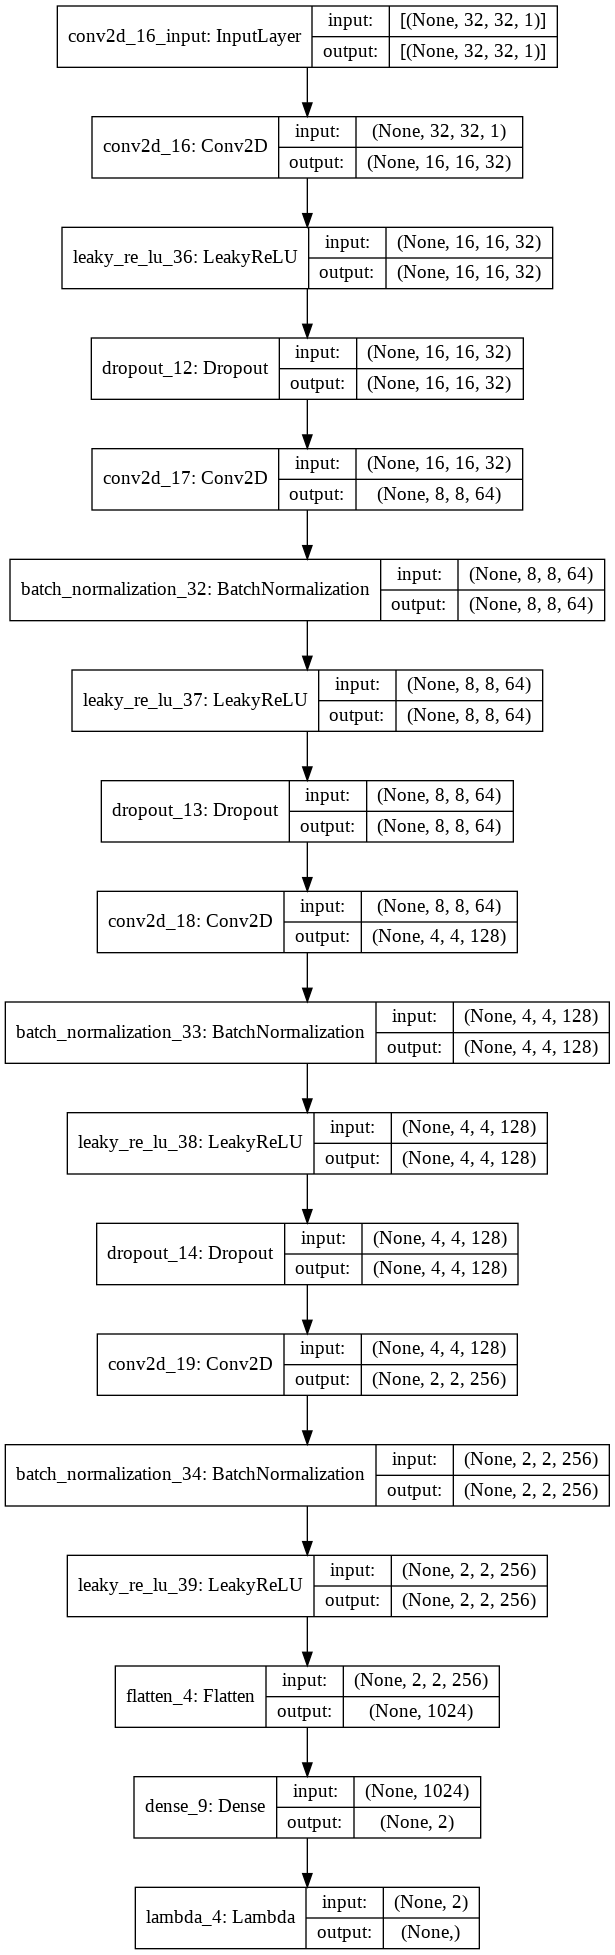

In [26]:
model_param_GAN_SVHN_1 = {'amsgrad_d': False,
 'amsgrad_g': False,
 'batch_size': 128,
 'beta_1_d': 0.2,
 'beta_1_g': 0.5,
 'beta_2_d': 0.999,
 'beta_2_g': 0.999,
 'critic_step': 1,
 'dataset': 'SVHN',
 'epsilon_d': 1e-07,
 'epsilon_g': 1e-07,
 'learning_rate_d': 0.0001,
 'learning_rate_g': 0.0001,
 'model': 'GAN',
 'save_model_freq': 25,
 'noise_dim': 128,
 'output': '/content/drive/My Drive/AML_Final_Project/GAN_Model_SVHN/attempt2/',
 'total_epoch': 25,
 'visualize': True,
  'gif': True}

GAN_model = GAN(model_param_GAN_SVHN_1)

# Summary of the generator and discriminator architechtures
GAN_model.G.summary()
GAN_model.D.summary()

# Saving the architecture information
make_dir_if_not_exists(GAN_model.out_path) 
plot_model(GAN_model.G, to_file=GAN_model.out_path + 'Generator_architecture.png', show_shapes=True)
plot_model(GAN_model.D, to_file=GAN_model.out_path + 'Discriminator _architecture.png', show_shapes=True)

In [6]:
# model_param_WGAN100drop = {'amsgrad_d': False,
#  'amsgrad_g': False,
#  'batch_size': 128,
#  'beta_1_d': 0.2,
#  'beta_1_g': 0.5,
#  'beta_2_d': 0.999,
#  'beta_2_g': 0.999,
#  'critic_step': 1,
#  'dataset': 'MNIST',
#  'epsilon_d': 1e-07,
#  'epsilon_g': 1e-07,
#  'learning_rate_d': 0.0001,
#  'learning_rate_g': 0.0001,
#  'model': 'WGANLP',
#  'noise_dim': 128,
#  'output': '/content/drive/My Drive/WGAN100',
#  'total_epoch': 100,
#  'visualize': True,
#   'gif': True}

In [27]:
# Training GAN model on MNIST Data
import random
random.seed(0)
GAN_model_SVHN_1, d_obj_GAN_model_SVHN_1, g_obj_GAN_model_SVHN_1 = fit_model(False,model_param_GAN_SVHN_1)
np.save(GAN_model_SVHN_1.out_path+"d_obj.npy",d_obj_GAN_model_SVHN_1)
np.save(GAN_model_SVHN_1.out_path+"g_obj.npy",g_obj_GAN_model_SVHN_1)
GAN_model_SVHN_1_gen_images = model_generate(GAN_model_SVHN_1,n=10000)

Using downloaded and verified file: ./AML_Final_Project/data/SVHN/train_32x32.mat
Training...
Time used for epoch 1 are 13.00 seconds.
Time used for epoch 2 are 24.09 seconds.
Time used for epoch 3 are 35.26 seconds.
Time used for epoch 4 are 46.00 seconds.
Time used for epoch 5 are 56.67 seconds.
Time used for epoch 6 are 67.32 seconds.
Time used for epoch 7 are 78.29 seconds.
Time used for epoch 8 are 89.07 seconds.
Time used for epoch 9 are 99.91 seconds.
Time used for epoch 10 are 110.78 seconds.
Time used for epoch 11 are 121.86 seconds.
Time used for epoch 12 are 132.63 seconds.
Time used for epoch 13 are 143.33 seconds.
Time used for epoch 14 are 154.29 seconds.
Time used for epoch 15 are 165.03 seconds.
Time used for epoch 16 are 175.81 seconds.
Time used for epoch 17 are 186.60 seconds.
Time used for epoch 18 are 197.66 seconds.
Time used for epoch 19 are 208.49 seconds.
Time used for epoch 20 are 219.30 seconds.
Time used for epoch 21 are 230.06 seconds.
Time used for epoch 2

ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f466e0fa730> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 388.8x388.8 with 1 Axes>

Using downloaded and verified file: ./AML Final Project/svhn/train_32x32.mat


ValueError: ignored

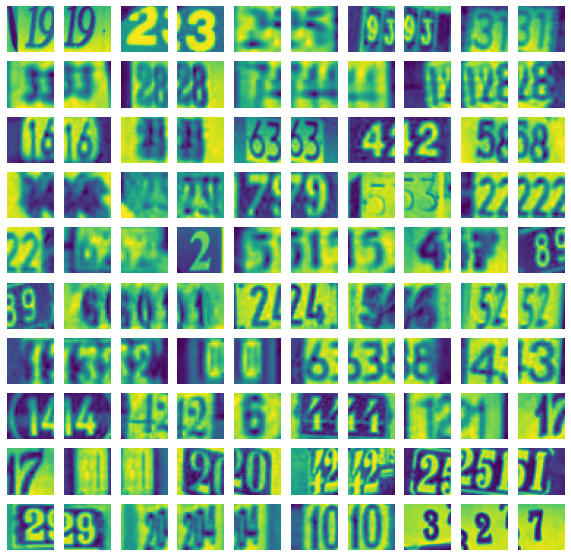

In [19]:
# from torchvision.datasets import SVHN
# # "content/drive/My Drive/AMP Final Project/SVHN Data/"
# # "content/drive/My Drive/AMP Final Project/SVHN Data/"reshape(gen_images.shape[0],1,gen_images.shape[2],gen_images.shape[3])
gen_images = torchvision.datasets.SVHN(root='./AML Final Project/svhn',split="train",download=True).data
gen_images = gen_images.mean(1)
# gen_images = tf.squeeze(gen_images.mean(1),axis=1)
# svhn_test_data_images = SVHN(root='./AML Final Project/svhn',split="test",download=True)
fig = plt.figure(figsize=(10, 10))
# plt.suptitle(plot_title)
for i in range(gen_images.shape[0]):
  plt.subplot(10, 10, i + 1)
  # if model.data_shape[3] == 1:
  #     plt.imshow(gen_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  # else:
  plt.imshow((gen_images[i, :, :] + 1) / 2)
  plt.axis('off')
# make_dir_if_not_exists(os.path.join(model.out_path, save_file_path.format(model.dataset)))
# plt.savefig(os.path.join(model.out_path, save_file_path.format(model.dataset)))
plt.clf()
plt.close(fig)

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

In [17]:
gen_images.mean(1).shape

(73257, 32, 32)